In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns


## Get some database statistics using API

Relevant search field that we will explore are

- report \
serious \
safetyreportid  \
reportercountry - country where the report occured \
senderorganization - name of the organization sending report \
transmissiondate - date the record was created \
qualification - category of individual who submitted report

- patient \
patientonsetage \
patientsex \
reactionmeddrapt - string explaining the reaction

- drug \
medicinalproduct - drug name \
drugindication \
drugcharacterization



In [2]:
url = 'https://api.fda.gov/drug/event.json?'
data = requests.get(url).json()

In [3]:
data

{'meta': {'disclaimer': 'Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service.',
  'terms': 'https://open.fda.gov/terms/',
  'license': 'https://open.fda.gov/license/',
  'last_updated': '2022-11-04',
  'results': {'skip': 0, 'limit': 1, 'total': 15600243}},
 'results': [{'safetyreportid': '5801206-7',
   'transmissiondateformat': '102',
   'transmissiondate': '20090109',
   'serious': '1',
   'seriousnessdeath': '1',
   'receivedateformat': '102',
   'receivedate': '20080707',
   'receiptdateformat': '102',
   'receiptdate': '20080625',
   'fulfillexpeditecriteria': '1',
   'companynumb': 'JACAN16471',
   'primarysource': {'reportercountry': 'CANADA', 'qualification': '3'},
   'sender': {'senderorganization': 'FDA-Public Use'},
   'receiver': None,
   'patient': {'patientonseta

## Amount of reports over years

In [4]:
url = 'https://api.fda.gov/drug/event.json?count=receiptdate'
data = requests.get(url).json()
df_time = pd.DataFrame(data.get("results"))
df_time.head()

,time,count
0,00901102,1
1,10100526,1
2,19080729,1
3,19190215,1
4,19281116,1


In [5]:
df_time = df_time.assign(time = pd.to_datetime(df_time.time, format=f"%Y%m%d", errors='coerce'))
df_time = df_time.dropna()
df_time.time = df_time.time.astype('datetime64[M]')

In [6]:
#select data from 2000 to 20003

dt_old = pd.Timestamp('2004-1-1')
dt_now = pd.Timestamp.now()

df_time=df_time[(df_time.time>dt_old)&(df_time.time<dt_now)]

<AxesSubplot: xlabel='date'>

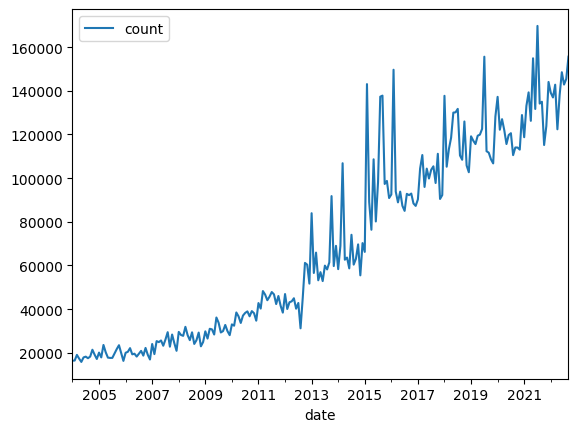

In [7]:
df_time = df_time.assign(month_year = df_time.time.dt.to_period('M'))
df_time_aux = df_time.groupby('month_year')['count'].sum().reset_index()
df_time_aux.plot(x='month_year', y='count', xlabel='date')

## Countries representation

In [8]:
url = 'https://api.fda.gov/drug/event.json?count=occurcountry.exact'
data = requests.get(url).json()
df_countries = pd.DataFrame(data.get("results"))
df_countries.head()

,term,count
0,US,8744571
1,CA,452068
2,GB,394012
3,JP,359842
4,FR,355787


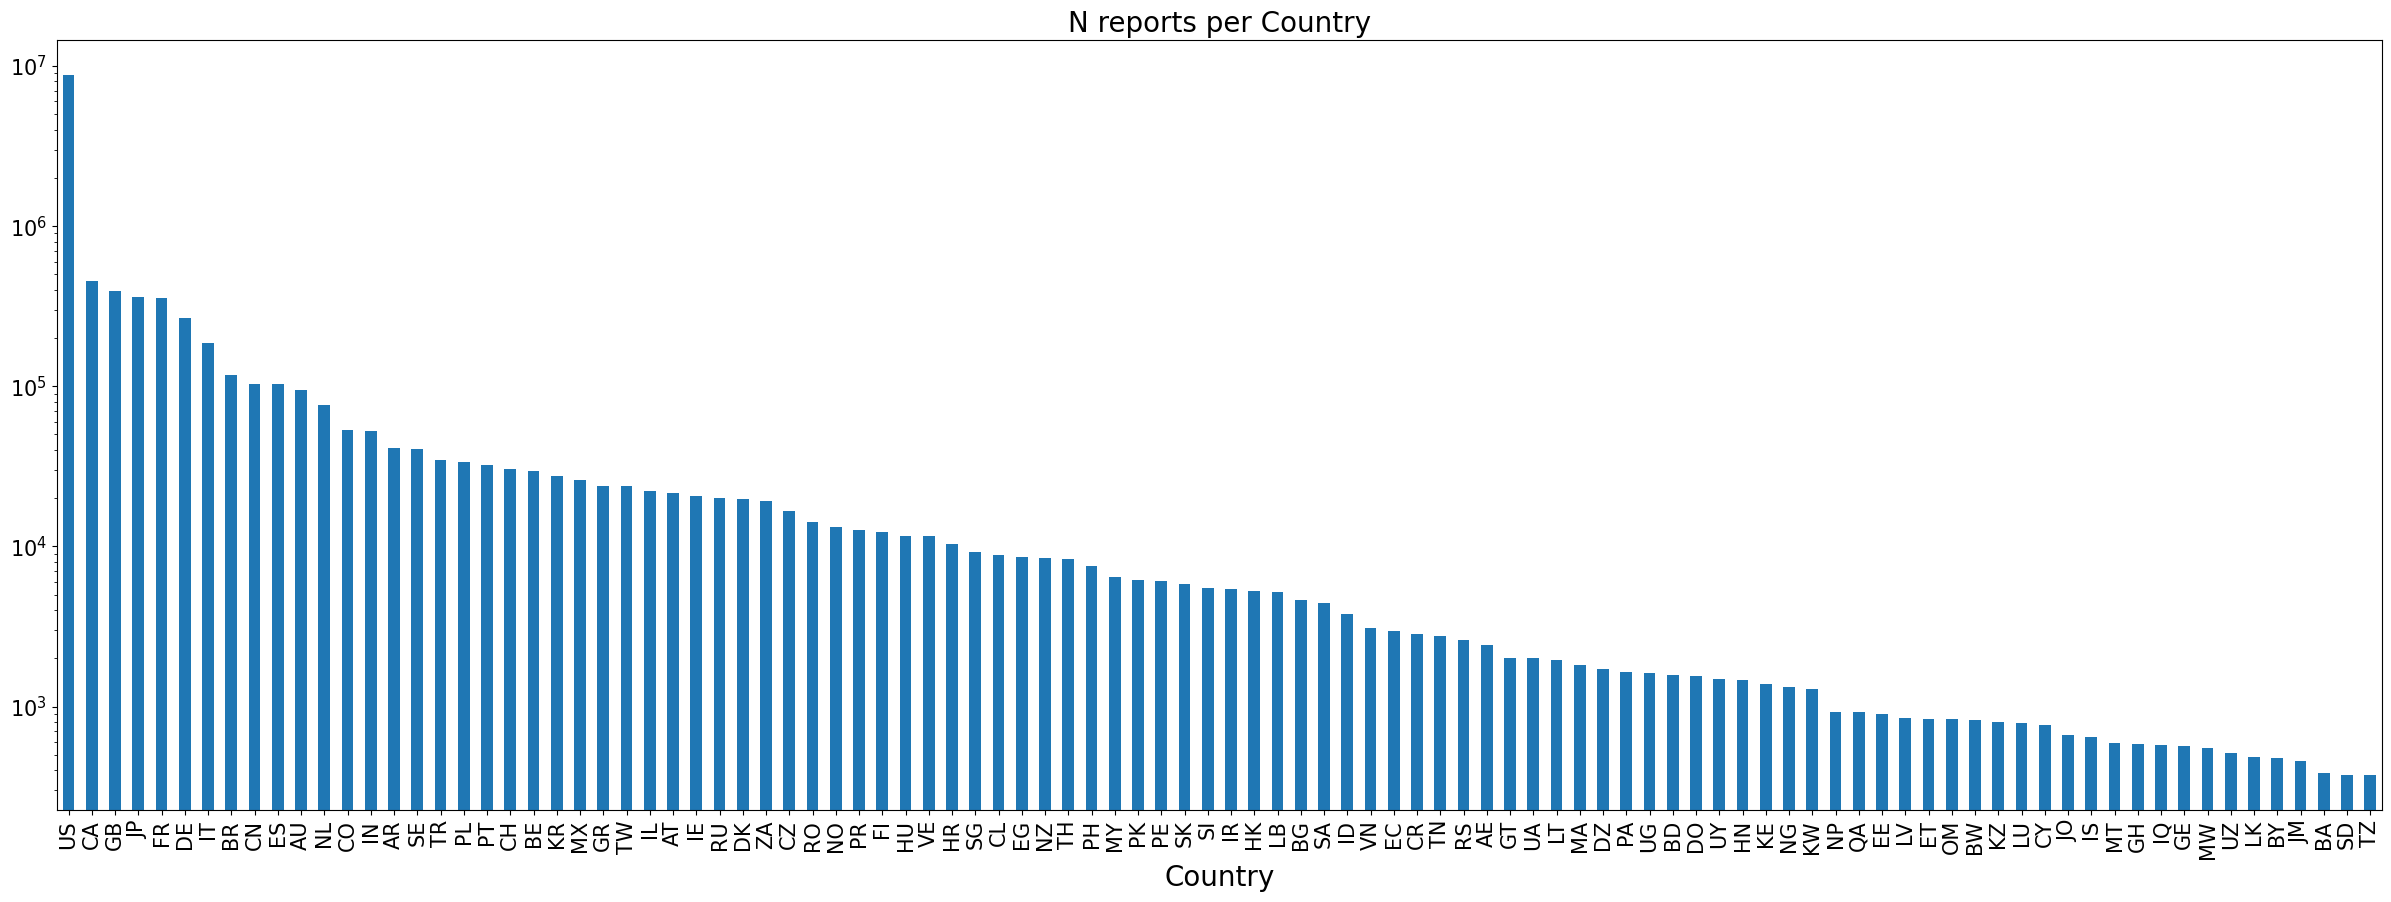

In [9]:
ax = df_countries.plot(kind='bar', x='term', y='count',figsize=(30, 10), logy=True, fontsize=15, xlabel='country', legend=False)
ax.set_xlabel('Country', fontsize=20);
ax.set_title('N reports per Country', fontsize=20);

Seems that most of the records come from the USA (note the logaritmics y scale).
Let's get the most reported adverse effects for each conutry

## Adverse events occuriencies

In [10]:
url = 'https://api.fda.gov/drug/event.json?count=patient.reaction.reactionmeddrapt.exact'
data = requests.get(url).json()
df_adv = pd.DataFrame(data.get("results"))
df_adv.head()

,term,count
0,DRUG INEFFECTIVE,986529
1,DEATH,640323
2,NAUSEA,600121
3,FATIGUE,574429
4,OFF LABEL USE,514112


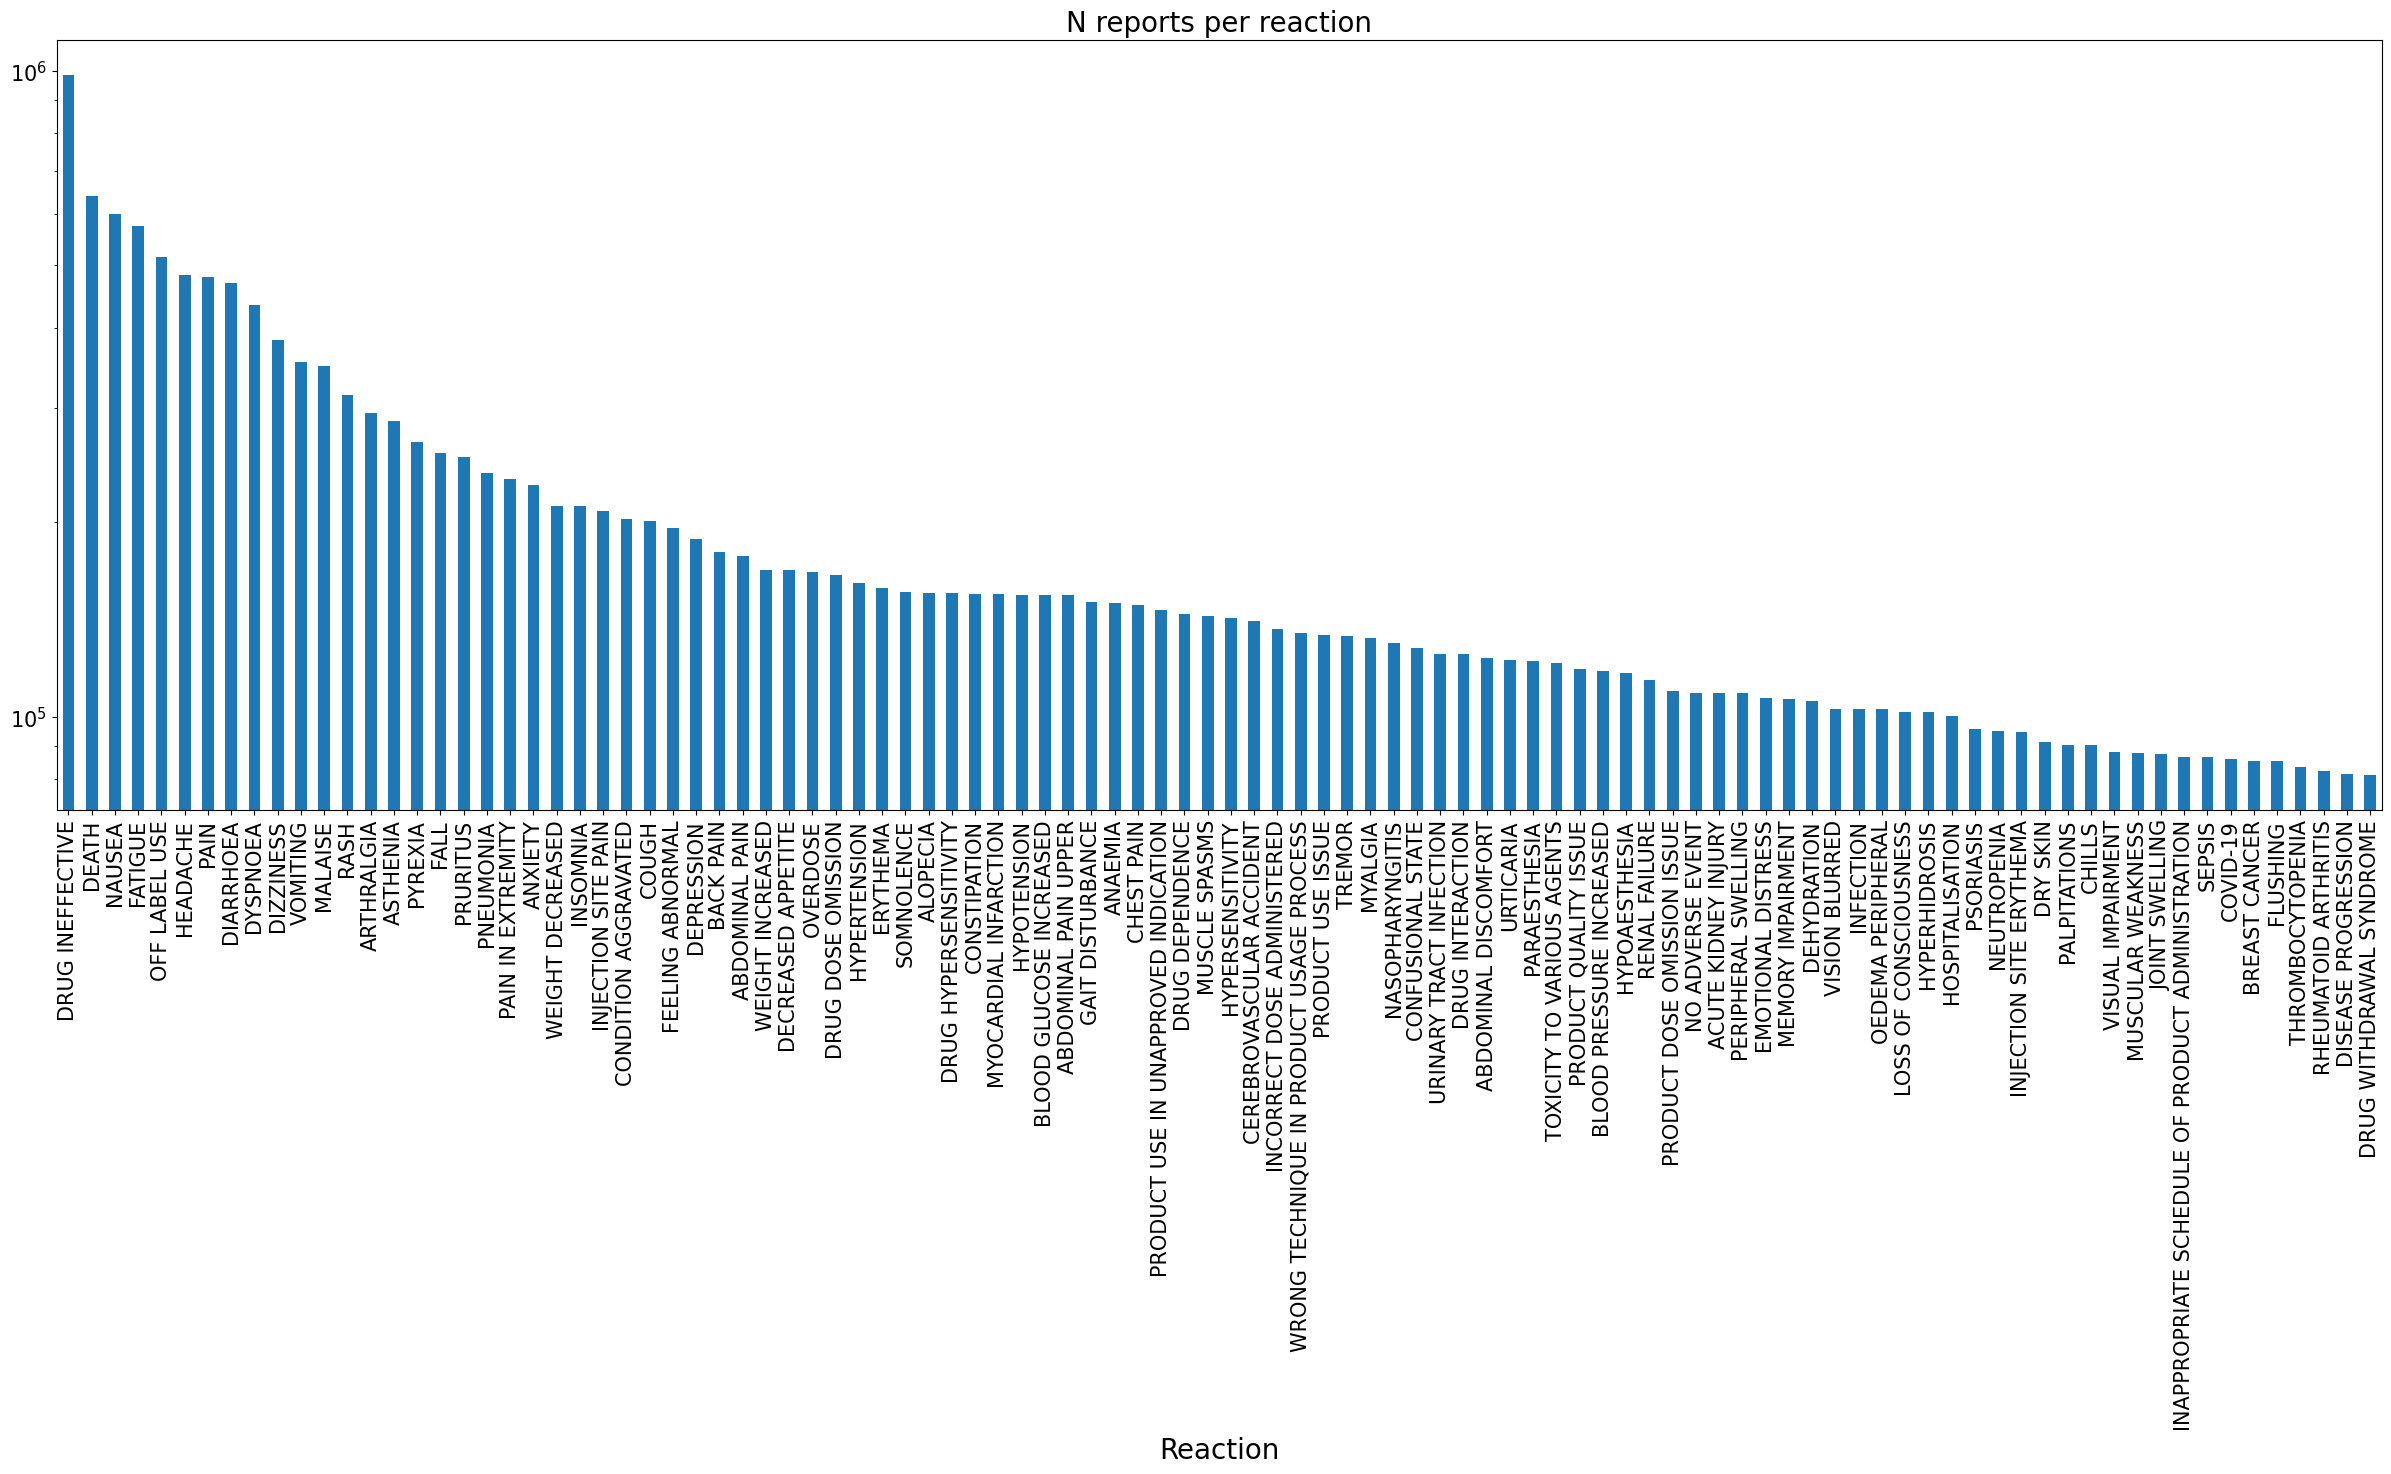

In [11]:
ax = df_adv.plot(kind='bar', x='term', y='count',figsize=(30, 10), logy=True, fontsize=15, xlabel='reaction', legend=False)
ax.set_xlabel('Reaction', fontsize=20);
ax.set_title('N reports per reaction', fontsize=20);

## Examine patientsex, patientage, serious

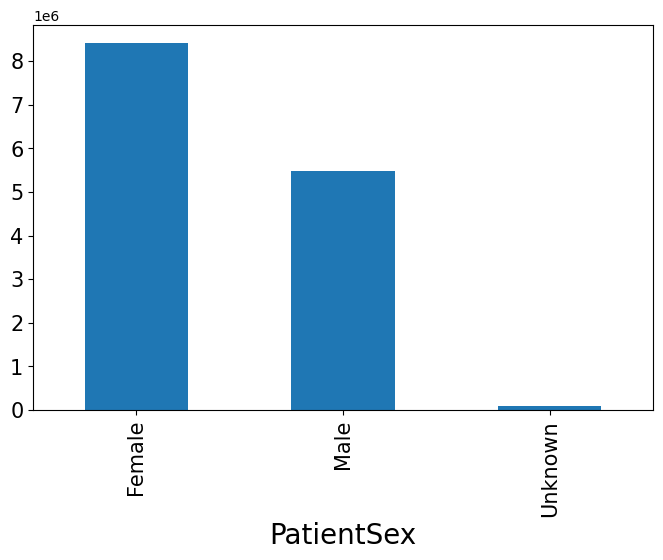

In [14]:

url = 'https://api.fda.gov/drug/event.json?count=patient.patientsex'
data = requests.get(url).json()
df_tmp = pd.DataFrame(data.get("results"))
df_tmp.term = df_tmp.term.replace({0:'Unknown', 1:'Male', 2:'Female'})
ax = df_tmp.plot(kind='bar', x='term', y='count',figsize=(8, 5), fontsize=15, xlabel='patientsex', legend=False)
ax.set_xlabel('PatientSex', fontsize=20);


There seem to be more reports for Females compared to Males; it might be related to gender- specific conditon (ie pregnancy) or indeed more pronounced adverse effects on females

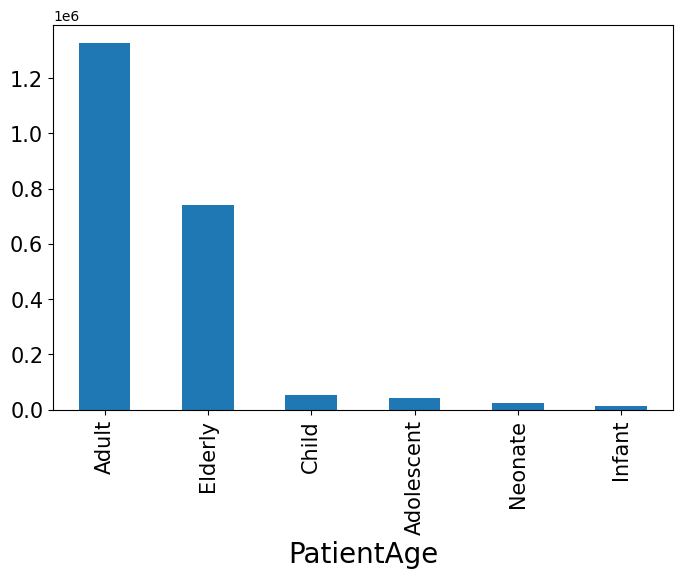

In [15]:
agemap = {1:'Neonate',
          2: 'Infant',
          3: 'Child',
          4: 'Adolescent',
          5: 'Adult',
          6: 'Elderly'}

url = 'https://api.fda.gov/drug/event.json?count=patient.patientagegroup'
data = requests.get(url).json()
df_tmp = pd.DataFrame(data.get("results"))
df_tmp.term = df_tmp.term.replace(agemap)
ax = df_tmp.plot(kind='bar', x='term', y='count',figsize=(8, 5), fontsize=15, xlabel='patientage', legend=False)
ax.set_xlabel('PatientAge', fontsize=20);

Most of the database consists of adults and elderly reports, it might be due to different medications taken in different age, or that adults/elderly are simply taking more medicines in general

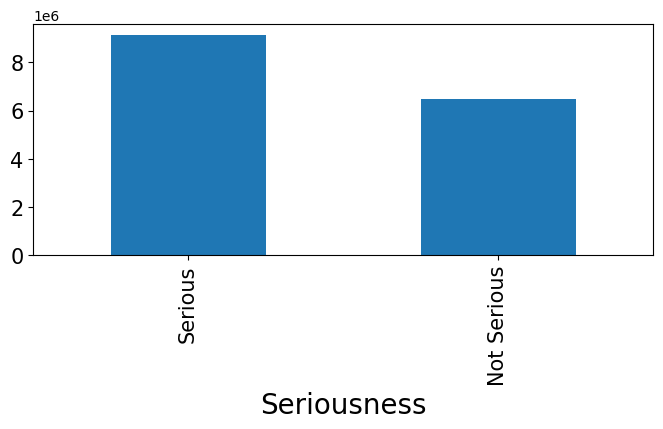

In [16]:
seriousmap = {1:'Serious',
              2: 'Not Serious'}
url = 'https://api.fda.gov/drug/event.json?count=serious'
data = requests.get(url).json()
df_tmp = pd.DataFrame(data.get("results"))
df_tmp.term = df_tmp.term.replace(seriousmap)
ax = df_tmp.plot(kind='bar', x='term', y='count',figsize=(8, 3), fontsize=15, legend=False)
ax.set_xlabel('Seriousness', fontsize=20);

## Check if different countries report different adverse reaction

In [17]:
def make_df_per_country(countr):
    url = f'https://api.fda.gov/drug/event.json?search=occurcountry:"{countr}".exact&count=patient.reaction.reactionmeddrapt.exact&limit=10'
    data = requests.get(url).json()
    tmp_df = pd.DataFrame(data.get("results"))
    return tmp_df.assign(country=countr)

In [18]:
df_countr_ev = pd.concat([make_df_per_country(x) for x in  df_countries.term.values[:10]], ignore_index=True)

In [21]:
df_countr_ev.head()

,term,count,country
0,DRUG INEFFECTIVE,665412,US
1,FATIGUE,336639,US
2,OFF LABEL USE,325713,US
3,DEATH,322895,US
4,NAUSEA,316738,US


In [22]:
countries_sorted = df_countries.term.values[:10]

In [53]:
#for each contry plot only 10 most frequent events
g = df_countr_ev.groupby('country', group_keys=False)
g = g.apply(lambda x: x.sort_values('count', ascending=False).head(10))

In [69]:
ev_count_count = pd.crosstab(g.term, g.country, values=g['count'], aggfunc='sum')
ev_count_count = ev_count_count.fillna(0)
ev_count_count = ev_count_count[countries_sorted]
ev_count_count.head()

country,US,CA,GB,JP,FR,DE,IT,BR,CN,ES
term,,,,,,,,,,
ACUTE KIDNEY INJURY,0.0,0.0,0.0,0.0,15654.0,0.0,0.0,0.0,0.0,3172.0
ANAEMIA,0.0,0.0,0.0,9787.0,0.0,0.0,6673.0,0.0,0.0,2688.0
ARTHRALGIA,0.0,32951.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ASTHENIA,0.0,0.0,0.0,0.0,9085.0,0.0,7753.0,5046.0,0.0,2849.0
DEATH,322895.0,30035.0,22746.0,9878.0,0.0,7962.0,0.0,6962.0,8585.0,2402.0


Lets plot 10 bar plots per country

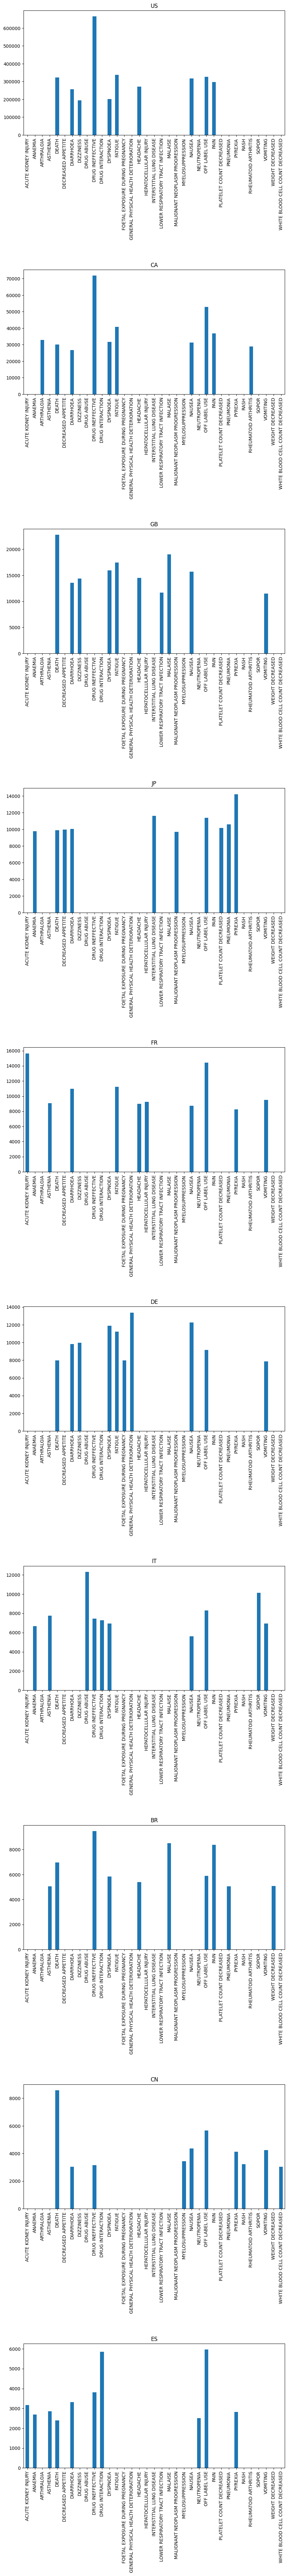

In [70]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(10, 80))
for indx, col in  enumerate(ev_count_count.columns):
    ax = axs[indx]
    group = ev_count_count[col]
    group.plot(ax=ax, kind='bar', x='term')
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    ax.set_title(col)
fig.tight_layout(pad=5.0)

We can also do a stacked barplot to easier compare different distributions between the countries, having checked in the previous plot that the total count of each reaction is indeed statistically significant. Since the US is overrepresented we have to normalize the counts per country to have cleaner visualization.

In [71]:
ev_count_norm = ev_count_count/ev_count_count.sum(axis=0)


(-0.5, 12.5)

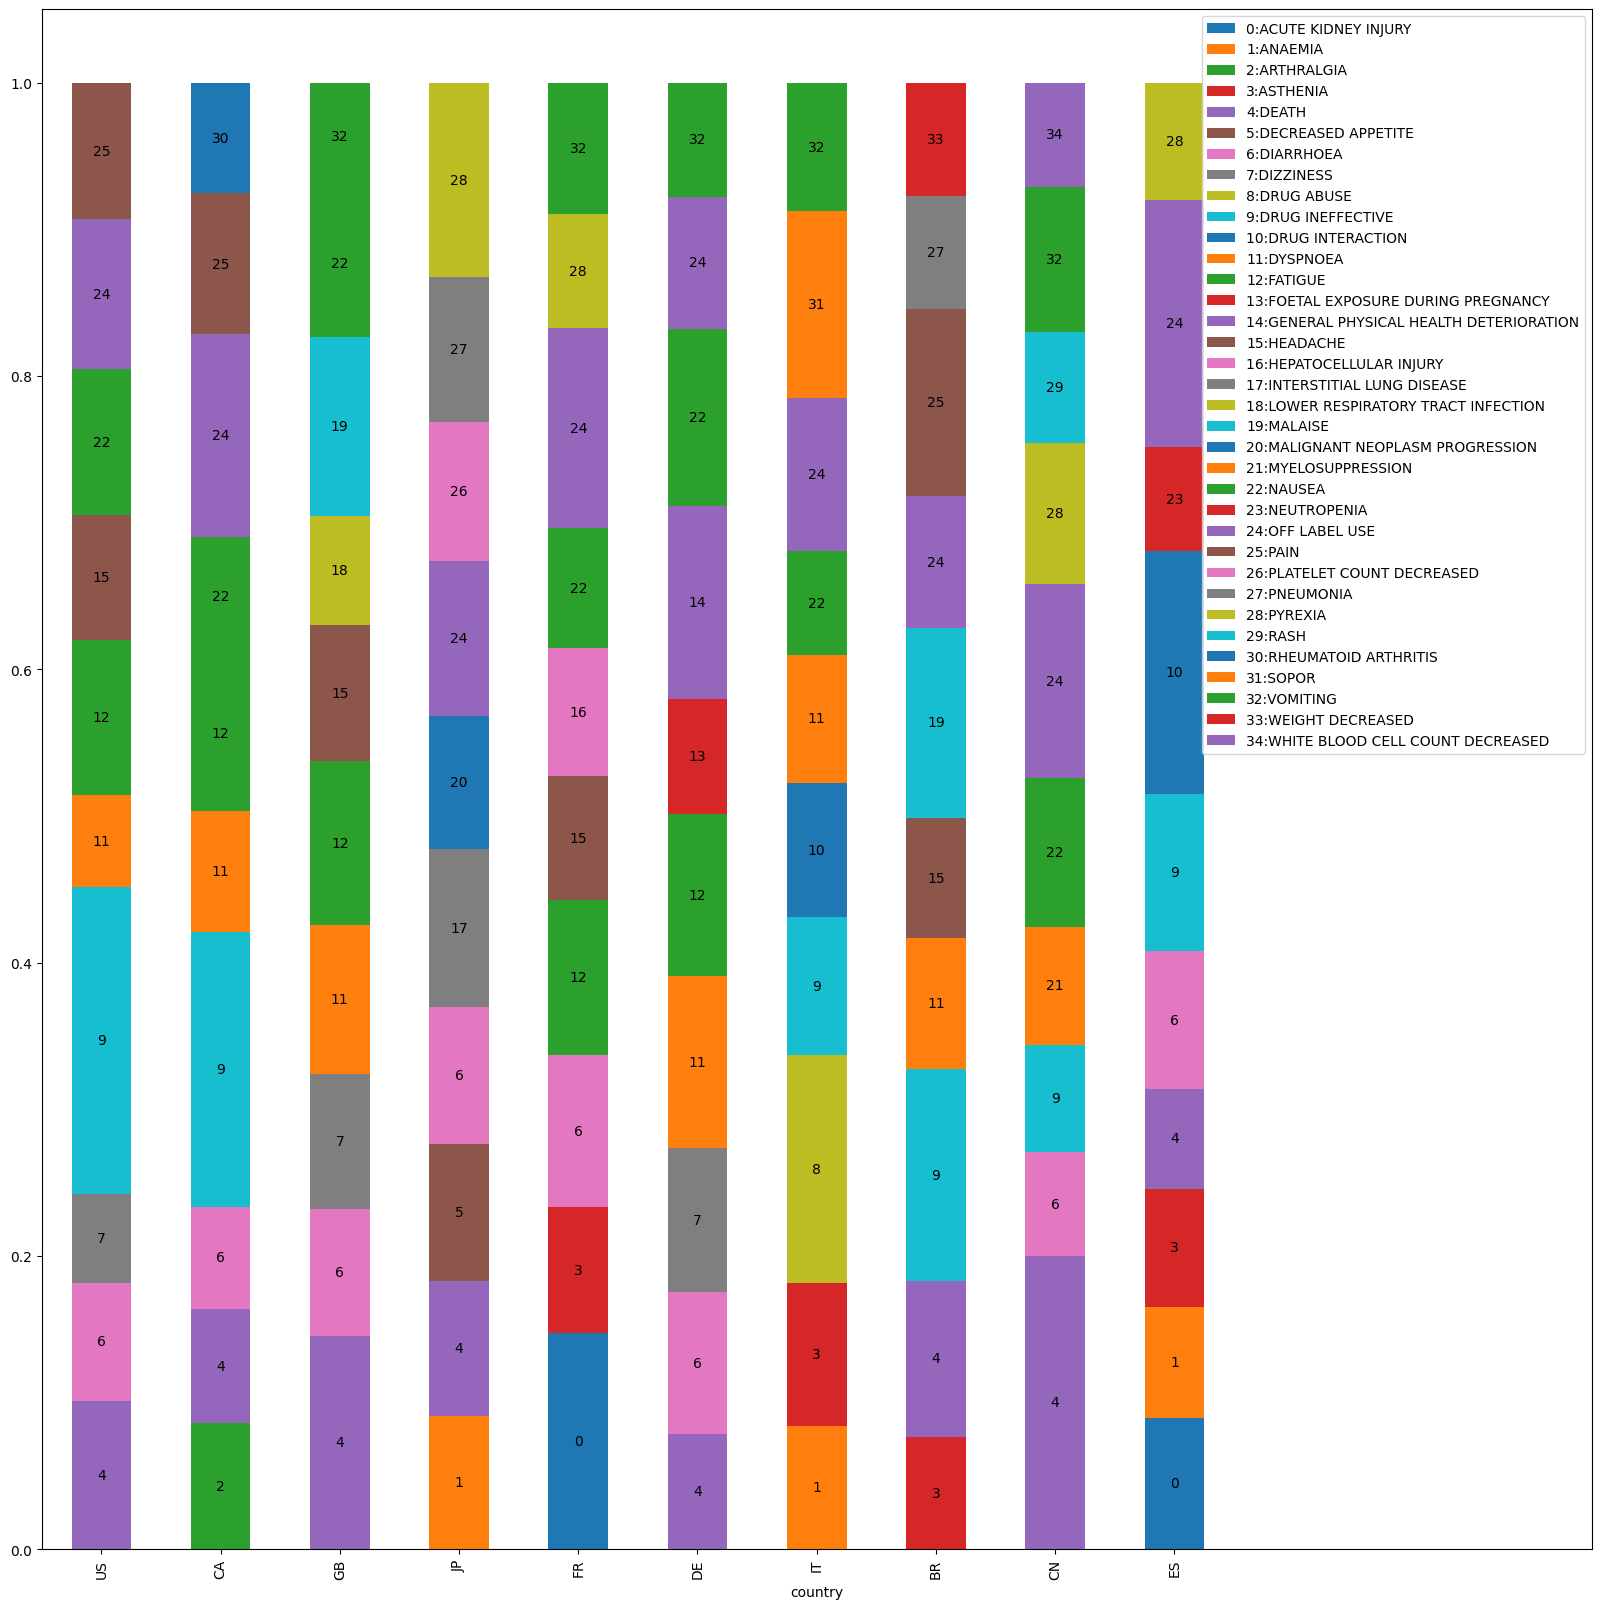

In [72]:
ax = ev_count_norm.T.plot(kind='bar', stacked=True, figsize=(20,20))
ax.get_xlim()
for i, c in enumerate(ax.containers):

    # Optional: if the segment is small or 0, customize the labels
    labels = [i if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')
handles, labels = ax.get_legend_handles_labels()
labels = [f'{i}:{label}' for i, label in enumerate(labels)]
ax.legend(handles, labels)
ax.set_xlim(-0.5, 12.5)

Seems FR and IT are te safest when it comes to DEATH adverse effect :)